# ResNet50 Pretrained Network with Fine Tuning 10 Last Layers

In this run for the ResNet50, we froze all layers but the last 10 and added two dense layers after the conv_base.

Results>

Best Epoch: 45

test acc: 0.82616

test loss: 3.47004

f1_score: 0.82131

Precision: 0.884906

Recall: 0.799

ROC AUC: 0.82616

---Training:  seconds --- 20697,7 s

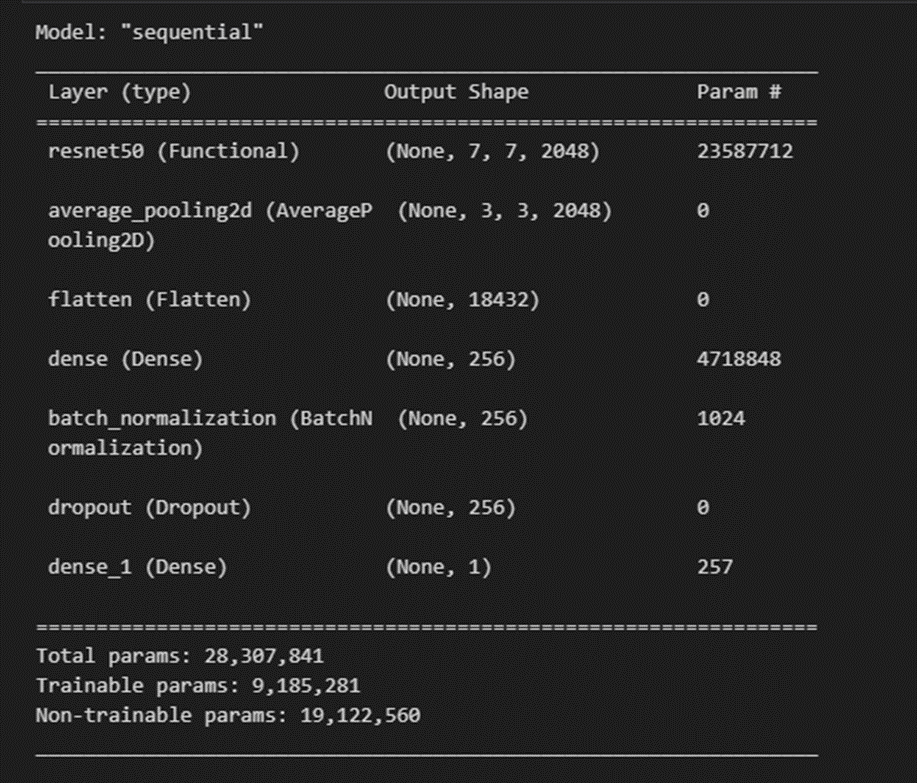

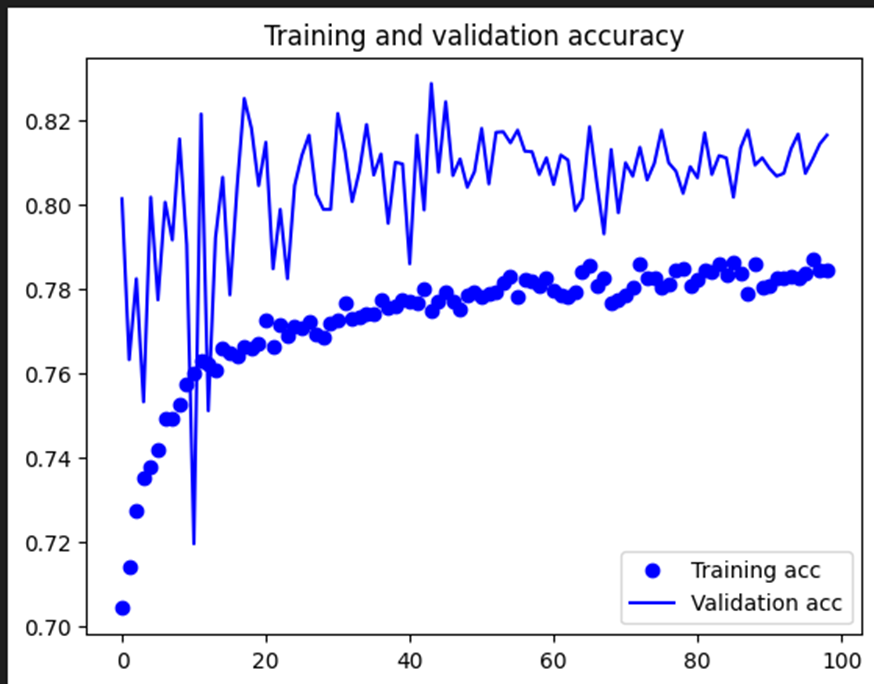

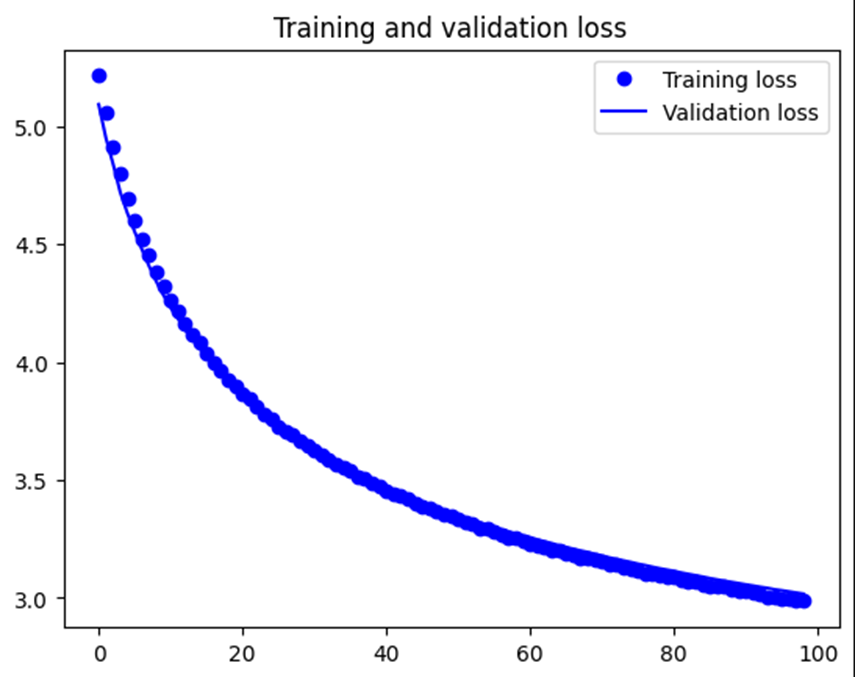

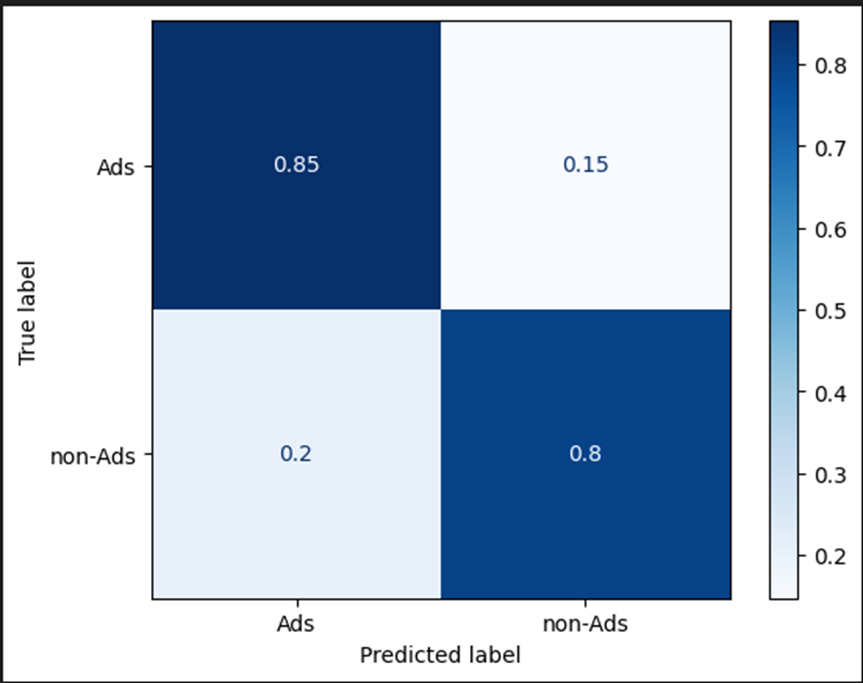




In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Thu Jun 20 08:40:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   46C    P8              16W / 125W |    673MiB /  6144MiB |     31%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 10
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Split Data

In [18]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [19]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [20]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Ads'

In [21]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir



'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [22]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [23]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [24]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [25]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [26]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [27]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [28]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


## Using data augmentation/ datagen

In [29]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [30]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [31]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [32]:
from keras.preprocessing.image import ImageDataGenerator
## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)


# train_datagen = ImageDataGenerator(
#     rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model ResNet50

In [33]:
import keras
from keras.models import load_model


The ResNEt50 model
https://datagen.tech/guides/computer-vision/resnet-50/#


In [34]:
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [35]:
conv_base.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We will add a dense layer after our conv_base NN

In [36]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D

modelPreTRes = models.Sequential()
modelPreTRes.add(conv_base)
modelPreTRes.add(layers.AveragePooling2D())
modelPreTRes.add(layers.Flatten())
modelPreTRes.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
modelPreTRes.add(BatchNormalization())
modelPreTRes.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreTRes.add(layers.Dense(1, activation='sigmoid'))

In [37]:
modelPreTRes.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0

# Fine Tuning

In [38]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [39]:
# Make last block of the conv_base trainable:

for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True

print('Last block of the conv_base is now trainable')

Last block of the conv_base is now trainable


In [40]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTRes.trainable_weights))

This is the number of trainable weights before freezing the conv base: 18


In [41]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [42]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTRes.trainable_weights))

This is the number of trainable weights before freezing the conv base: 18


In [43]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [44]:
modelPreTRes.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])# Adagrad, adam

In [45]:
modelPreTRes.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0

In [46]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [47]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001) #Factor by which the learning rate will be reduced

In [48]:
print(TrainingConfig.EPOCHS)

100


In [49]:
import time
start_time = time.time()

In [50]:
histPreT = modelPreTRes.fit(train_generator, epochs = TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback, reduce_lr]) #  epochs 10 are over fitting. early stop at?

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.6346 - accuracy: 0.6661
Epoch 1: val_accuracy improved from -inf to 0.72211, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-01-0.7221.keras
329/329 [==============================] - 212s 625ms/step - loss: 5.6346 - accuracy: 0.6661 - val_loss: 5.4076 - val_accuracy: 0.7221 - lr: 0.0010
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.3964 - accuracy: 0.7043
Epoch 2: val_accuracy improved from 0.72211 to 0.80145, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\model-02-0.8014.keras
329/329 [==============================] - 207s 628ms/step - loss: 5.3964 - accuracy: 0.7043 - val_loss: 5.1635 - val_accuracy: 0.8014 - lr: 0.0010
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 5.2383 - accuracy: 0.7142
Epoch 3: val_accuracy did not improve from 0.80145
329/329 [==============================] - 203s 617ms/ste

Investigate profilers the GPU cuda usage

https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

In [51]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 20697.71301317215 seconds ---


In [52]:
#modelPreTRes.save(os.path.join('models/Latest','Pretrained_RenNet50_ad_class_with_Aug.h5'))

In [53]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [54]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [55]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_ResNet50_FT10', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [56]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 45


In [57]:
START_PLOT_FROM_EPOCH= 1

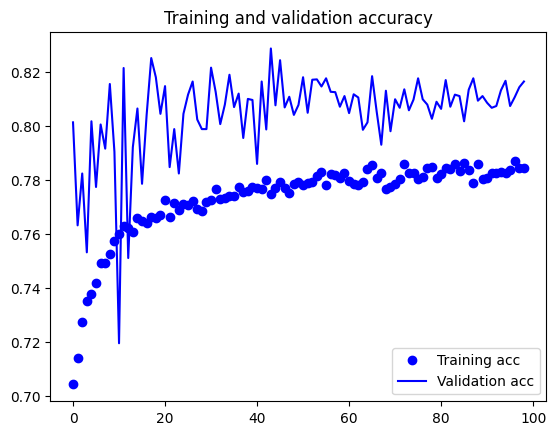

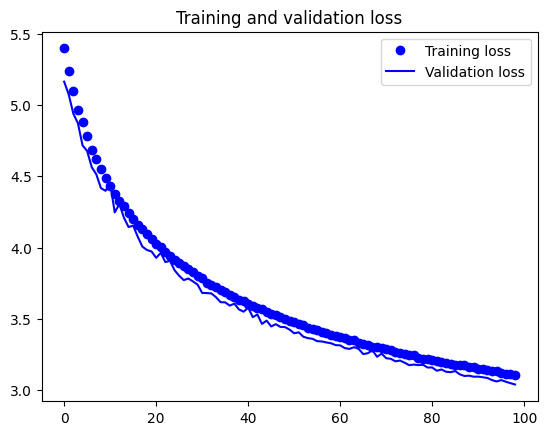

In [58]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [59]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 45


# Loading best epoch in our model using the checkpoints

In [60]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' # C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints

In [61]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

Best model file: model-45-0.8288.keras


In [62]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [63]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'model-01-0.5987.keras',
 'model-01-0.7221.keras',
 'model-02-0.8014.keras',
 'model-06-0.8018.keras',
 'model-10-0.8157.keras',
 'model-13-0.8216.keras',
 'model-19-0.8253.keras',
 'model-45-0.8288.keras']

In [65]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('model-45-0.8288.keras') 
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0

## Evaluate

In [66]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [67]:
start_time = time.time()

In [68]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.EPOCHS,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 6000 images belonging to 2 classes.
60/60 [==============================] - 22s 321ms/step - loss: 3.4700 - accuracy: 0.8262
test acc: 0.8261666893959045
test loss: 3.470048427581787


In [69]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 22.587673902511597 Training set > seconds ---


In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [71]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = loaded_model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

4/4 [==============================] - 0s 92ms/step


In [72]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [73]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2560,  440],
       [ 603, 2397]], dtype=int64)

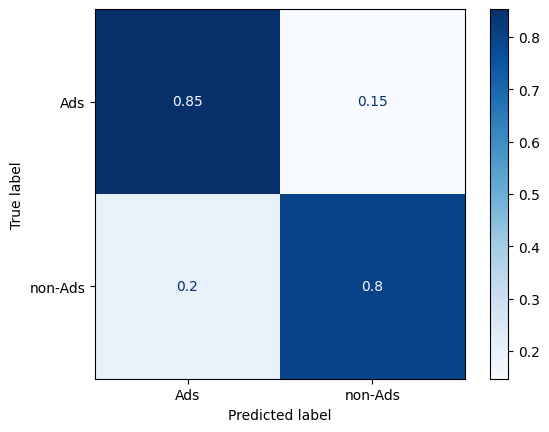

In [74]:
# Plot the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm_sum.astype(float), display_labels=['Ads', 'non-Ads'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [75]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [76]:

f1_score(true_labels, predicted_labels)

0.8213123179715608

In [77]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.8449065914698626

In [78]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.799

In [79]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.826167
